In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from google.colab import files
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, Bidirectional

In [ ]:
uploaded = files.upload()

Btc = pd.read_csv('Cleaned_Price.csv')

Saving Cleaned_Price.csv to Cleaned_Price.csv


In [ ]:
Btc.head()

,Unnamed: 0,Date,Open,High,Low,Close,Volume,Year,Month
0,0,2014-09-17,465.864014,468.174011,452.421997,457.334015,21056800.0,2014,9
1,1,2014-09-18,456.859985,456.859985,413.104004,424.440002,34483200.0,2014,9
2,2,2014-09-19,424.102997,427.834991,384.532013,394.795990,37919700.0,2014,9
3,3,2014-09-20,394.673004,423.295990,389.882996,408.903992,36863600.0,2014,9
4,4,2014-09-21,408.084991,412.425995,393.181000,398.821014,26580100.0,2014,9


In [ ]:
Btc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2721 entries, 0 to 2720
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  2721 non-null   int64  
 1   Date        2721 non-null   object 
 2   Open        2721 non-null   float64
 3   High        2721 non-null   float64
 4   Low         2721 non-null   float64
 5   Close       2721 non-null   float64
 6   Volume      2721 non-null   float64
 7   Year        2721 non-null   int64  
 8   Month       2721 non-null   int64  
dtypes: float64(5), int64(3), object(1)
memory usage: 191.4+ KB


In [ ]:
Btc1 = Btc[['Date','Open','Close']] # Extracting required columns
Btc1['Date'] = pd.to_datetime(Btc1['Date'].apply(lambda x: x.split()[0])) # Selecting only date
Btc1.set_index('Date',drop=True,inplace=True) # Setting date column as index
Btc1.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,Open,Close
Date,,
2014-09-17,465.864014,457.334015
2014-09-18,456.859985,424.440002
2014-09-19,424.102997,394.795990
2014-09-20,394.673004,408.903992
2014-09-21,408.084991,398.821014


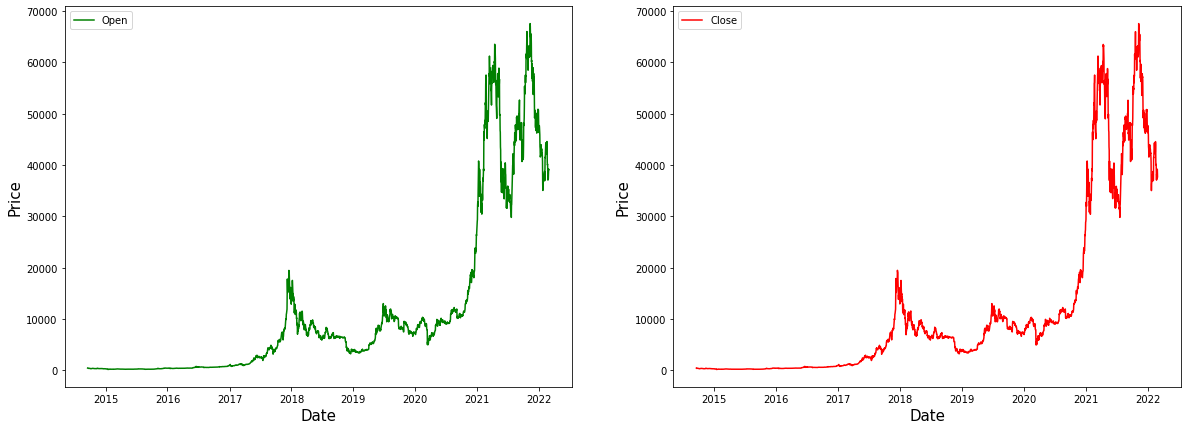

In [ ]:
fg, ax =plt.subplots(1,2,figsize=(20,7))
ax[0].plot(Btc1['Open'],label='Open',color='green')
ax[0].set_xlabel('Date',size=15)
ax[0].set_ylabel('Price',size=15)
ax[0].legend()

ax[1].plot(Btc1['Close'],label='Close',color='red')
ax[1].set_xlabel('Date',size=15)
ax[1].set_ylabel('Price',size=15)
ax[1].legend()

fg.show()

In [ ]:
MMS = MinMaxScaler()
Btc1[Btc1.columns] = MMS.fit_transform(Btc1)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


In [ ]:
Btc1.shape

(2721, 2)

In [ ]:
training_size = round(len(Btc1) * 0.65) # Selecting 65 % for training and 35 % for testing
training_size

1769

In [ ]:
train_data = Btc1[:training_size]
test_data  = Btc1[training_size:]

train_data.shape, test_data.shape

((1769, 2), (952, 2))

In [ ]:
def create_sequence(dataset):
  sequences = []
  labels = []

  start_idx = 0

  for stop_idx in range(50,len(dataset)): # Selecting 50 rows at a time
    sequences.append(dataset.iloc[start_idx:stop_idx])
    labels.append(dataset.iloc[stop_idx])
    start_idx += 1
  return (np.array(sequences),np.array(labels))

In [ ]:
train_seq, train_label = create_sequence(train_data)
test_seq, test_label = create_sequence(test_data)

In [ ]:
train_seq.shape, train_label.shape, test_seq.shape, test_label.shape

((1719, 50, 2), (1719, 2), (902, 50, 2), (902, 2))

In [ ]:
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape = (train_seq.shape[1], train_seq.shape[2])))

model.add(Dropout(0.1)) 
model.add(LSTM(units=50))

model.add(Dense(2))

model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_absolute_error'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 50, 50)            10600     
                                                                 
 dropout (Dropout)           (None, 50, 50)            0         
                                                                 
 lstm_1 (LSTM)               (None, 50)                20200     
                                                                 
 dense (Dense)               (None, 2)                 102       
                                                                 
Total params: 30,902
Trainable params: 30,902
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.fit(train_seq, train_label, epochs=80,validation_data=(test_seq, test_label), verbose=1)

Epoch 1/80
54/54 [==============================] - 17s 162ms/step - loss: 4.4829e-04 - mean_absolute_error: 0.0119 - val_loss: 0.0052 - val_mean_absolute_error: 0.0461
Epoch 2/80
54/54 [==============================] - 3s 52ms/step - loss: 1.0662e-04 - mean_absolute_error: 0.0057 - val_loss: 0.0068 - val_mean_absolute_error: 0.0537
Epoch 3/80
54/54 [==============================] - 3s 52ms/step - loss: 8.3973e-05 - mean_absolute_error: 0.0051 - val_loss: 0.0060 - val_mean_absolute_error: 0.0498
Epoch 4/80
54/54 [==============================] - 3s 52ms/step - loss: 8.1981e-05 - mean_absolute_error: 0.0053 - val_loss: 0.0081 - val_mean_absolute_error: 0.0590
Epoch 5/80
54/54 [==============================] - 4s 66ms/step - loss: 6.7754e-05 - mean_absolute_error: 0.0046 - val_loss: 0.0073 - val_mean_absolute_error: 0.0558
Epoch 6/80
54/54 [==============================] - 3s 52ms/step - loss: 6.4084e-05 - mean_absolute_error: 0.0044 - val_loss: 0.0075 - val_mean_absolute_error: 0.0

In [ ]:
test_predicted = model.predict(test_seq)
test_predicted[:5]

array([[0.15400343, 0.15365675],
       [0.1510501 , 0.15074867],
       [0.15140666, 0.1510757 ],
       [0.15449794, 0.15406619],
       [0.15427318, 0.1538128 ]], dtype=float32)

In [ ]:
test_inverse_predicted = MMS.inverse_transform(test_predicted) # Inversing scaling on predicted data
test_inverse_predicted[:5]

array([[10552.545, 10532.835],
       [10353.571, 10336.863],
       [10377.594, 10358.902],
       [10585.861, 10560.427],
       [10570.719, 10543.351]], dtype=float32)

In [ ]:
# Merging actual and predicted data for better visualization

gs_slic_data = pd.concat([Btc1.iloc[-902:].copy(),pd.DataFrame(test_inverse_predicted,columns=['open_predicted','close_predicted'],index=Btc1.iloc[-902:].index)], axis=1)

In [ ]:
gs_slic_data[['Open','Close']] = MMS.inverse_transform(gs_slic_data[['Open','Close']]) # Inverse scaling

In [ ]:
gs_slic_data.head()

,Open,Close,open_predicted,close_predicted
Date,,,,
2019-09-10,10336.408203,10115.975586,10552.544922,10532.834961
2019-09-11,10123.035156,10178.372070,10353.571289,10336.863281
2019-09-12,10176.819336,10410.126953,10377.593750,10358.902344
2019-09-13,10415.362305,10360.546875,10585.861328,10560.426758
2019-09-14,10345.403320,10358.048828,10570.718750,10543.350586


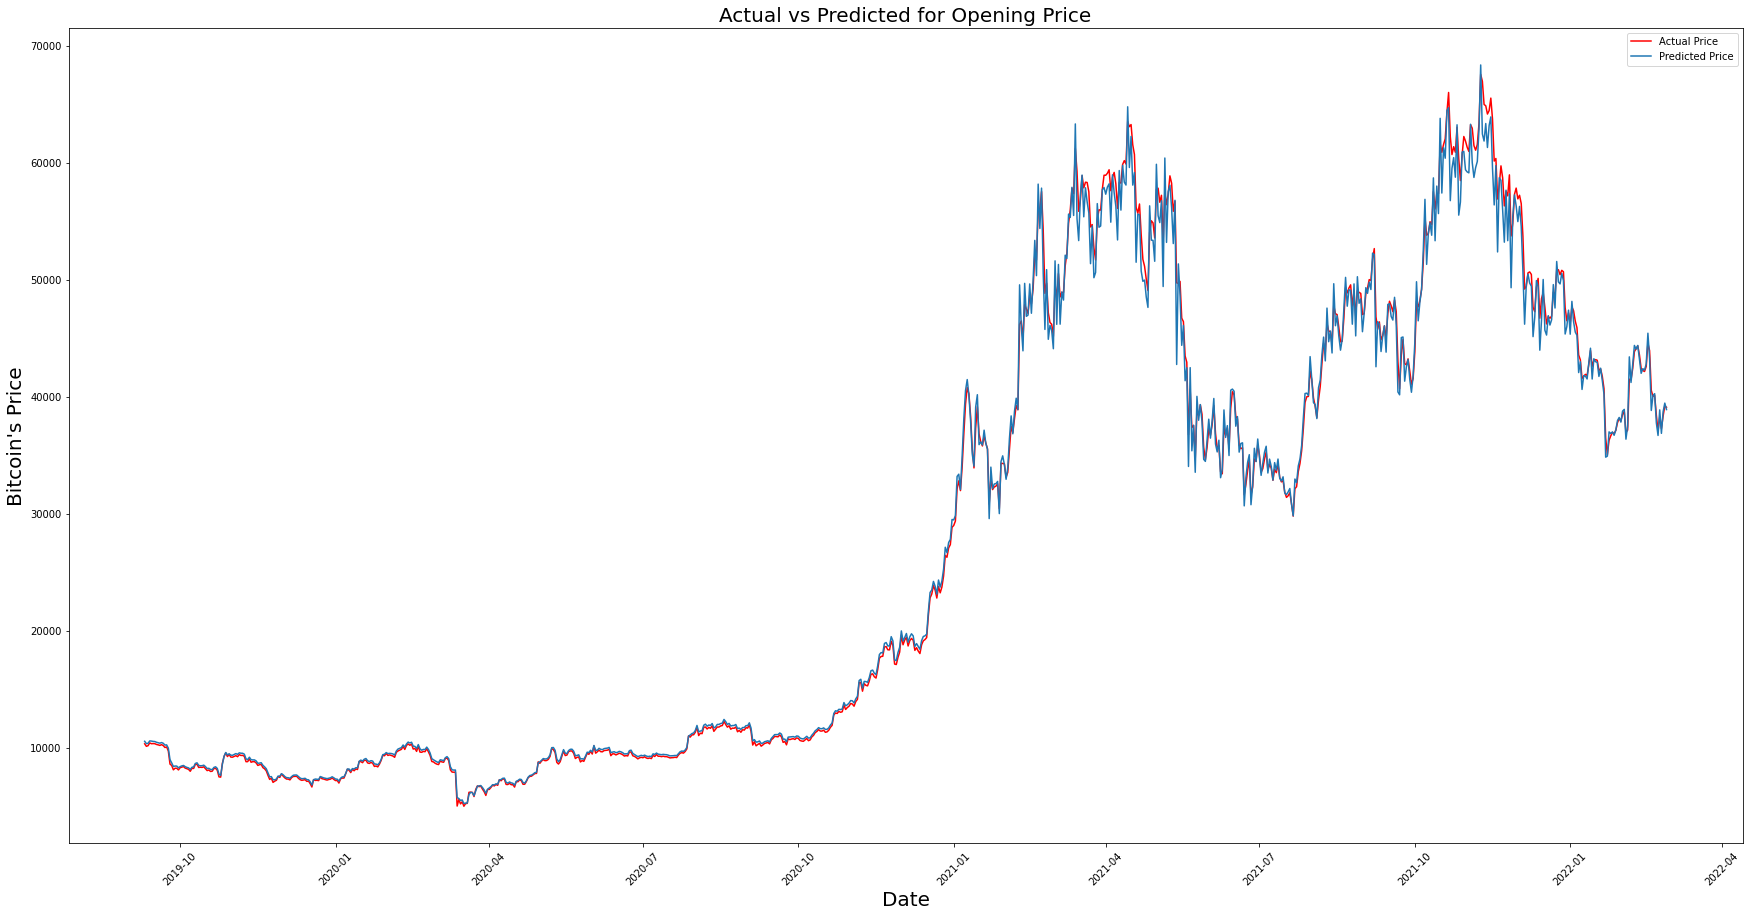

In [ ]:
plt.figure(figsize=(30,15))
plt.plot(gs_slic_data['Open'], color='red', label='Actual Price')
plt.plot(gs_slic_data['open_predicted'], label='Predicted Price')
plt.xticks(rotation=45)
plt.xlabel('Date',size=20)
plt.legend()
plt.ylabel('Bitcoin\'s Price',size=20)
plt.title('Actual vs Predicted for Opening Price',size=20)
plt.show()

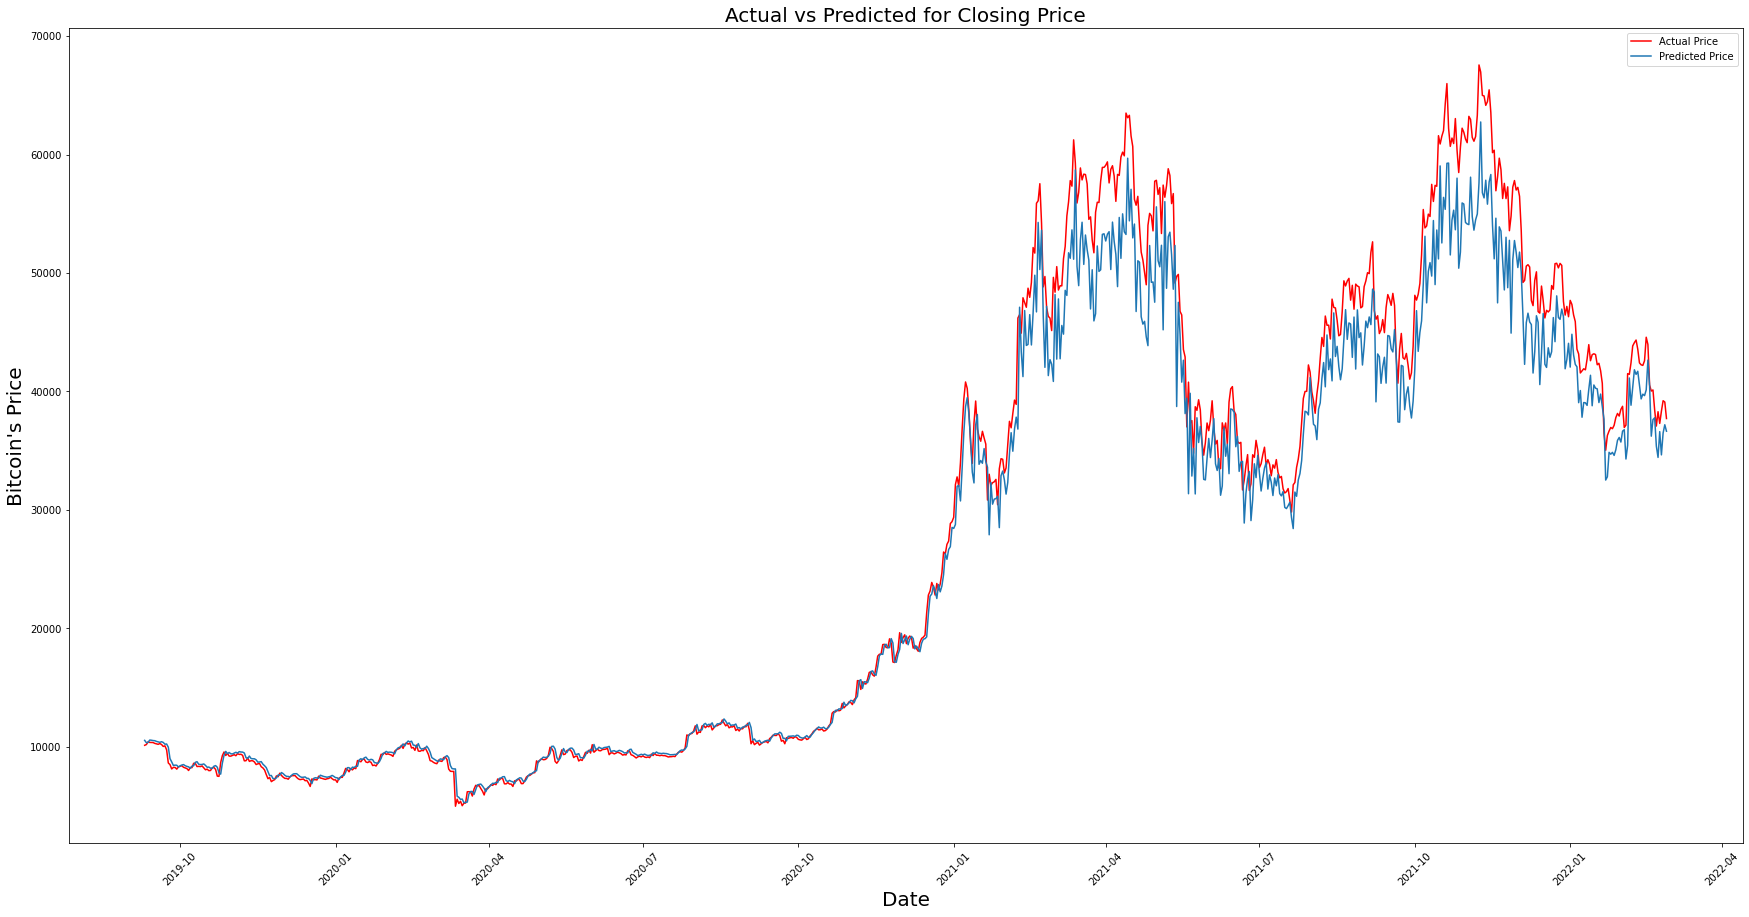

In [ ]:
#gs_slic_data[['Close','close_predicted']].plot(figsize=(10,6))
plt.figure(figsize=(30,15))
plt.plot(gs_slic_data['Close'], color='red', label='Actual Price')
plt.plot(gs_slic_data['close_predicted'], label='Predicted Price')
plt.xticks(rotation=45)
plt.xlabel('Date',size=20)
plt.legend()
plt.ylabel('Bitcoin\'s Price',size=20)
plt.title('Actual vs Predicted for Closing Price',size=20)
plt.show()

In [ ]:
# Forecast Error

#machinelearningmastery.com/time-series-forecasting-performance-measures-with-python
import statistics
import math
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
forecast_errors = [gs_slic_data['Open'][i] - gs_slic_data['open_predicted'][i] for i in range(len(gs_slic_data))]


#Mean Forecast Error

mean_forecast_eror = statistics.mean(forecast_errors)

print(mean_forecast_eror)

# Forecast errors can be positive and negative. This means that when the average of these values is calculated, an ideal mean forecast error would be zero.

# A mean forecast error value other than zero suggests a tendency of the model to over forecast (negative error) or under forecast (positive error). As such, the mean forecast error is also called the forecast bias.

# The forecast error can be calculated directly as the mean of the forecast values. The example below demonstrates how the mean of the forecast errors can be calculated manually.

forecast_errors1 = [gs_slic_data['Close'][i] - gs_slic_data['close_predicted'][i] for i in range(len(gs_slic_data))]


#Mean Forecast Error

mean_forecast_eror1 = statistics.mean(forecast_errors1)

print(mean_forecast_eror1)


bias = sum(forecast_errors) * 1.0/len(gs_slic_data)
print('Bias: %f' % bias)

#Running the example prints the mean forecast error, also known as the forecast bias.
#In this case the result is negative, meaning that we have over forecast.

bias1 = sum(forecast_errors1) * 1.0/len(gs_slic_data)
print('Bias: %f' % bias1)

#Mean Absolute Error

MAE = mean_absolute_error(gs_slic_data['Open'],gs_slic_data['open_predicted'])
print(MAE)
MAE1 = mean_absolute_error(gs_slic_data['Close'],gs_slic_data['close_predicted'])
print(MAE1)

#Mean Squared Error
MSE = mean_squared_error(gs_slic_data['Open'],gs_slic_data['open_predicted'])
print(MSE)
MSE1 = mean_squared_error(gs_slic_data['Close'],gs_slic_data['close_predicted'])
print(MSE1)

#RMSE

print(math.sqrt(MSE))
print(math.sqrt(MSE1))

#R2 Score

print(r2_score(gs_slic_data['Open'],gs_slic_data['open_predicted']))
print(r2_score(gs_slic_data['Close'],gs_slic_data['close_predicted']))

137.07748576559007
1684.2401770489187
Bias: 137.077486
Bias: 1684.240177
578.3960713314855
1937.5654362299056
1025314.1599716544
10002410.646012094
1012.5779772302252
3162.6587938018374
0.9972642816072114
0.9732795835386285
